# Looking at hydroxyl hydrogen interactions
(Author: David Mobley, UC Irvine)


In this notebook, we look at LJ interactions involving polar hydrogens in smirnoff99Frosst. These initially have an LJ radius of zero, following GAFF/AMBER family force fields, but this causes crashes. Here we explore potentially adding very small LJ parameters to avoid crashes while not overly perturbing thermodynamics.

To some extent, this follows the strategy used for the parm@Frosst type HX, which was all hydroxyl hydrogens EXCEPT those in water-like environments. That had an rmin_half of 0.6 (same as polar hydrogens on nitrogens) and an epsilon of 0.0157 (AMBER units). 

Here, Chris Bayly's suggestions were:
* Make the rmin_half be half that of the amide nitrogen, so 0.3
* "Adjust the epsilon so there is no attraction (but no repulsion either) from outside the bonded oxygen's repulsive vdw radius."

In smirnoff99Frosst, the relevant oxygen is ` <Atom smirks="[#8X2H1+0:1]" epsilon="0.2104" id="n20" rmin_half="1.7210"/>`

Here we will graph LJ interactions involving a hydroxyl hydrogen for these parameters, marking the distance of the oxygen's LJ radius, and see what this suggests for an epsilon value.

The HX-OH/HO-OH bond has a length of 0.96 angstroms.

## Van der Waals parameters in AMBER

It's a bit tricky to actually find the right vdW functional form in AMBER; after Googling I eventually found this expression: http://ambermd.org/vdwequation.pdf . We have values for $r_0 = (2)^\frac{1}{6} \sigma$. The relevant expression overall is:
\begin{equation}
E_{VDW} = 4 \epsilon \left[ \frac{1}{4} \left(\frac{r_0}{r}\right)^{12} - \frac{1}{2} \left(\frac{r_0}{r}\right)^6 \right]
\end{equation}

## Now let's proceed to analyze/graph

1.5332366939195239 A
0.5732366939195239 A 0.7610000000000001 A


Text(0,0.5,'Energy (kcal/mol)')

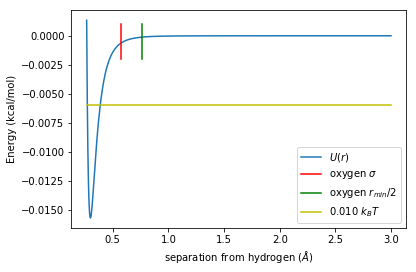

In [16]:
% matplotlib inline
from simtk import unit
import numpy as np
from pylab import *

# Input values we're considering
hydrogen_rminhalf = 0.3*unit.angstrom
hydrogen_epsilon = 0.0157*unit.kilocalorie_per_mole #Start with what HX had 
bondlength=0.96*unit.angstroms
oxygen_rminhalf = 1.7210*unit.angstroms

# Figure out distance from oxygen sigma to hydrogen
oxygen_sigma = oxygen_rminhalf/(2**(1/6))
print(oxygen_sigma)
# Compute the distance from hydrogen to oxygen sigma/oxygen rmin_half
# H and O are separated by bondlength, so we offset the distances by that amount
sigma_to_h = oxygen_sigma - bondlength
rminhalf_to_h = oxygen_rminhalf - bondlength
print(sigma_to_h, rminhalf_to_h)

# Generate a grid of rvalues, starting a bit before the oxygen outer edge
rvals = np.arange(0.35*rminhalf_to_h/unit.angstroms, 3.0, 1e-6)*unit.angstroms


# Define function to compute interaction energy (in this case between two identical particles, otherwise we'd be using combination rules)
def energy(r, r0, epsilon):
    e = 4*epsilon*(1/4*(r0/r)**12 - 1/2*(r0/r)**6)
    return e

# Compute energy
en = energy( rvals, hydrogen_rminhalf, hydrogen_epsilon)

# Graph
plot(rvals, en)

# Draw vertical line on graph where oxygen outer "edge" lies, measured in terms of sigma and rminhalf
# The oxygen lies some distance away from the 
xvals_sigma = np.array([sigma_to_h/unit.angstrom, sigma_to_h/unit.angstrom])*unit.angstrom
yvals = np.array([-2e-3, 1e-3])*unit.kilocalorie_per_mole
plot( xvals_sigma, yvals, 'r-')
xvals_sigma = np.array([rminhalf_to_h/unit.angstrom, rminhalf_to_h/unit.angstrom])*unit.angstrom
plot( xvals_sigma, yvals, 'g-')

#Draw horizontal line at some fraction of kB*T for perspective
fraction = 0.01 # 1% of kB T
yvals = -np.array([fraction, fraction])*unit.constants.BOLTZMANN_CONSTANT_kB*300*unit.kelvin* unit.constants.AVOGADRO_CONSTANT_NA/unit.kilocalorie_per_mole
xvals = np.array([0.35*rminhalf_to_h/unit.angstroms, 3.0])*unit.angstroms
plot( xvals, yvals, 'y-')

legend( [r'$U(r)$', r'oxygen $\sigma$', r'oxygen $r_{min}/2$', r'%.3f $k_B T$' % fraction])

#Do axis labels
xlabel(r'separation from hydrogen ($\AA$)')
ylabel('Energy (kcal/mol)')

## Analyis of the above

It seems that if we set a fairly restrictive tolerance on LJ interactions -- that we want LJ interactions to be less than 0.01 $k_B T$ by the time we reach the outside edge of the connected oxygen (measured by either $r_{min}/2$ or $\sigma$) we are still very much on safe ground in either case, as indicated by the yellow line (the tolerance) relative to the blue line at the red and green tick marks in the above figure.

However, the curve above is for hydrogen-hydrogen interactions only. Interactions between these hydrogens and other, non-hydrogen atoms will be relatively stronger, with well depths given by the combination rule $\epsilon_{ij} = \sqrt{ \epsilon_i \epsilon_j }$. Let's take a quick look and see what some of the largest \epsilon values are for `smirnoff99Frosst` and see how the situation above would change in that case. 

It looks like the largest is for cesium (ions) where we have `<Atom smirks="[#55+1:1]" epsilon="0.4065394" id="n32" rmin_half="1.976"/>`, so $\epsilon = 0.4065394$ kcal/mol; iodine is similar with a value of $0.4$ kcal/mol.

So, let's repeat the above analysis but where we graph the potential for a combined interaction of $\epsilon_{ij} = \sqrt{0.4\times0.0157} = 0.08$ kcal/mol

1.5332366939195239 A
0.5732366939195239 A 0.7610000000000001 A


Text(0,0.5,'Energy (kcal/mol)')

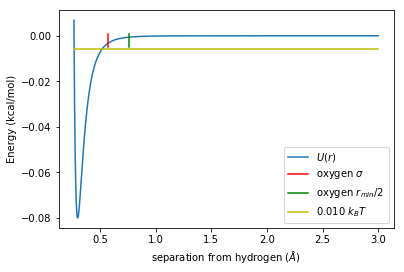

In [17]:
# Input values we're considering
hydrogen_rminhalf = 0.3*unit.angstrom
hydrogen_epsilon = 0.08*unit.kilocalorie_per_mole #Combined interaction parameter for hydrogen and iodine
bondlength=0.96*unit.angstroms
oxygen_rminhalf = 1.7210*unit.angstroms

# Figure out distance from oxygen sigma to hydrogen
oxygen_sigma = oxygen_rminhalf/(2**(1/6))
print(oxygen_sigma)
# Compute the distance from hydrogen to oxygen sigma/oxygen rmin_half
# H and O are separated by bondlength, so we offset the distances by that amount
sigma_to_h = oxygen_sigma - bondlength
rminhalf_to_h = oxygen_rminhalf - bondlength
print(sigma_to_h, rminhalf_to_h)

# Generate a grid of rvalues, starting a bit before the oxygen outer edge
rvals = np.arange(0.35*rminhalf_to_h/unit.angstroms, 3.0, 1e-6)*unit.angstroms


# Define function to compute interaction energy (in this case between two identical particles, otherwise we'd be using combination rules)
def energy(r, r0, epsilon):
    e = 4*epsilon*(1/4*(r0/r)**12 - 1/2*(r0/r)**6)
    return e

# Compute energy
en = energy( rvals, hydrogen_rminhalf, hydrogen_epsilon)

# Graph
plot(rvals, en)

# Draw vertical line on graph where oxygen outer "edge" lies, measured in terms of sigma and rminhalf
# The oxygen lies some distance away from the 
xvals_sigma = np.array([sigma_to_h/unit.angstrom, sigma_to_h/unit.angstrom])*unit.angstrom
yvals = np.array([-5e-3, 1e-3])*unit.kilocalorie_per_mole
plot( xvals_sigma, yvals, 'r-')
xvals_sigma = np.array([rminhalf_to_h/unit.angstrom, rminhalf_to_h/unit.angstrom])*unit.angstrom
plot( xvals_sigma, yvals, 'g-')

#Draw horizontal line at some fraction of kB*T for perspective
fraction = 0.01 # 1% of kB T
yvals = -np.array([fraction, fraction])*unit.constants.BOLTZMANN_CONSTANT_kB*300*unit.kelvin* unit.constants.AVOGADRO_CONSTANT_NA/unit.kilocalorie_per_mole
xvals = np.array([0.35*rminhalf_to_h/unit.angstroms, 3.0])*unit.angstroms
plot( xvals, yvals, 'y-')

legend( [r'$U(r)$', r'oxygen $\sigma$', r'oxygen $r_{min}/2$', r'%.3f $k_B T$' % fraction])

#Do axis labels
xlabel(r'separation from hydrogen ($\AA$)')
ylabel('Energy (kcal/mol)')

In [18]:
# Let's pull the exact value at the red tick mark and compare to 0.01 kBT
threshold = np.where(rvals>sigma_to_h)
first = threshold[0][0]
print(first)
print("Energy at sigma:", en[first])
kBT = unit.constants.BOLTZMANN_CONSTANT_kB*300*unit.kelvin* unit.constants.AVOGADRO_CONSTANT_NA 
print(kBT)
print("That's %.3f percent of kB T" % (np.abs(en[first]/kBT)*100))

306887
Energy at sigma: -0.00325355156761 kcal/mol
2494.341741366065 J/mol
That's 0.546 percent of kB T


## Further analysis

That certainly seems to be a reasonable number, but the value for the polar hydrogen here is pretty arbitrary; currently we've obtained it by taking the well depth and radius for the amide nitrogen (which is significant) and arbitrarily reducing the radius to make it somewhat less significant, but we have just adopted the existing well depth. There is no good justification for doing this; I'd rather have a value which is obtained from some actual analysis.

Why don't we instead do this: Take the strongest interaction (as in the analysis just done) and make it equal to 0.1% of $K_bT$ at the smaller radius -- in other words, rather than being content with the 0.55% we just saw, let's make it even smaller and use that value. What value does that equate to? It means we need to make the $\epsilon$ for hydrogen smaller by some factor so that the final $\epsilon$, $\sqrt{ \epsilon_i \epsilon_j }$ is smaller by a factor of 5.46:

In [19]:
#Find by what factor total epsilon needs to be smaller
factor = np.abs(en[first]/kBT)/0.001
print(factor)

# Find by what factor epsilon needs to be smaller
epsilon_factor = factor**2

# Compute new epsilon
hydrogen_new_epsilon = 0.0157*unit.kilocalorie_per_mole/epsilon_factor
print("Potential new epsilon", hydrogen_new_epsilon)

5.4574958728
Potential new epsilon 0.000527124036877 kcal/mol


### Check that we've got this right

In [20]:
# Input values we're considering
hydrogen_rminhalf = 0.3*unit.angstrom
hydrogen_epsilon = np.sqrt(0.4*hydrogen_new_epsilon/unit.kilocalorie_per_mole)*unit.kilocalorie_per_mole
bondlength=0.96*unit.angstroms
oxygen_rminhalf = 1.7210*unit.angstroms

# Compute energy
en = energy( rvals, hydrogen_rminhalf, hydrogen_epsilon)

# Check that we've got the results right
print("Energy at sigma:", en[first])
print(kBT)
print("That's %.3g percent of kB T" % (np.abs(en[first]/kBT)*100))

# Print final value
print("Final proposed hydrogen epsilon:", hydrogen_new_epsilon)

Energy at sigma: -0.000590546518421 kcal/mol
2494.341741366065 J/mol
That's 0.0991 percent of kB T
Final proposed hydrogen epsilon: 0.000527124036877 kcal/mol


### Summary

The above analysis suggests a final hydrogen epsilon of $0.000527$ kcal/mol, which will make sure that even the strongest inter-atom interactions are less than 0.1% of $k_BT$ outside of the oxygen atom's radius.

### Plan of next actions

Discussed further with Chris Bayly and Caitlin Bannan; Chris argues that it should be easy to find a set of parameters which will remove crashes, so the first test should be to apply these parameters to (for example) water just as a test, to ensure that the density is not dramatically perturbed and that the average enthalpy, etc., remains similar. We will not, of course, ultimately use these parameters for water, but that's a good check. Following that, he suggests that we look at  dimer energies as we bring molecules together -- should see that there's a singularity now and that the new parameters remove them. We could look at water dimers, or acetic acid dimers, or water-acetic acid dimer, or ... 

So plan of attack would be:
1) Run density calculation with TIP3P and with TIP3P modified to use these parameters
2) Look at dimer energetics with original parameters and modified parameters to verify we see the problem and can remove it
3) If both of the above look good, proceed to validation.

## Load TIP3P water and set up and dump an OpenMM system with normal parameters


In [21]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk import unit
from sys import stdout
import numpy as np
from mdtraj.formats.gro import load_gro
import parmed
from copy import deepcopy

# Prep the original system with TIP3P
# Load PDB
pdb = PDBFile('spc216.pdb')
# Load normal OpenMM water forcefield
forcefield = ForceField( 'tip3p.xml')
# get periodic box vectors
gro = load_gro('spc216.gro')
pdb.topology.setPeriodicBoxVectors(gro.openmm_boxes(0))

system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=0.6*unit.nanometer, constraints=HBonds, rigidWater = True)

# Dump XML
system_serialized = openmm.XmlSerializer.serialize(system)
file = open('tip3p_216.xml', 'w')
file.write(system_serialized)
file.close()

## Create a new system and modify TIP3P water to use new parameters

In [22]:
# Generate new system
system2 = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=0.6*unit.nanometer, constraints=HBonds, rigidWater = True)

# Final parameters to use for protons
hydrogen_epsilon = 0.000527*unit.kilocalorie_per_mole
hydrogen_rminhalf = 0.3*unit.angstrom
# Convert rminhalf to sigma
hydrogen_sigma = hydrogen_rminhalf/(2**(1/6))



# Retrieve nonbondedforce
for force in system2.getForces():
    if isinstance(force, openmm.NonbondedForce):
        break

# Update nonbonded force for protons
for residue in pdb.topology.residues():
    
    oxygen_index = None
    hydrogen_indices = []
    for atom in residue.atoms():
        if atom.element.name=='oxygen':
            continue
        elif atom.element.name=='hydrogen':
            # Update parameters for force on this atom
            chg, sigma, epsilon = force.getParticleParameters( atom.index )
            # Update
            force.setParticleParameters(atom.index, chg, hydrogen_sigma, hydrogen_epsilon)
            
            
# Dump XML
system_serialized = openmm.XmlSerializer.serialize(system2)
file = open('tip3p_modified_216.xml', 'w')
file.write(system_serialized)
file.close()

## Now exit this notebook and run density calculation from XML in this directory

I ran the `density.py` script for TIP3P and modified TIP3P water; results went into the `results` directory. Here we'll try and do a bit of analysis of them/some quick plots of the density convergence.

## Analyze runs of TIP3P water -- density results, etc.


In [1]:
import numpy
import pandas as pd
from pymbar import timeseries as ts
#tip3p = numpy.loadtxt('results/prod/tip3p_216_prod.csv', delimiter=",")
#tip3p_new = numpy.loadtxt('results/prod/tip3p_modified_216_prod.csv', delimiter=",")
tip3p = pd.read_csv('results/prod/tip3p_216_prod.csv', names=["step", "U", "Temperature", "Density"], skiprows=1)
tip3p_new = pd.read_csv('results/prod/tip3p_modified_216_prod.csv', names=["step", "U", "Temperature", "Density"], skiprows=1)

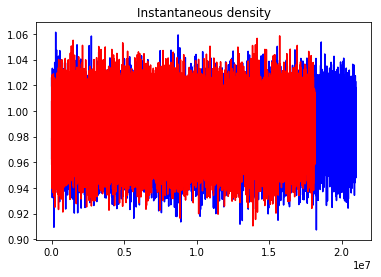

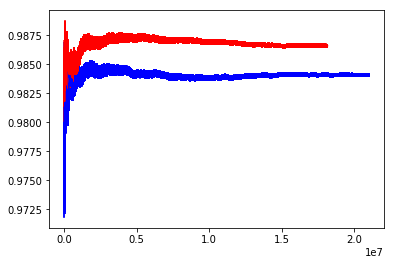

In [2]:
%matplotlib inline
from pylab import *

# Plot instantaneous density for original and new
plot( np.array(tip3p.step), np.array(tip3p.Density), 'b-')
plot( np.array(tip3p_new.step), np.array(tip3p_new.Density), 'r-')
title('Instantaneous density')

# Clip out unequilibrated region
density_ts = np.array(tip3p.Density)
[t0, g, Neff] = ts.detectEquilibration(density_ts, nskip=1000)
density_ts = density_ts[t0:]
stepnrs = np.array(tip3p.step[t0:])
density_ts_new = np.array(tip3p_new.Density)
[t0, g, Neff] = ts.detectEquilibration(density_ts_new, nskip=1000)
density_ts_new = density_ts_new[t0:]
stepnrs_new = np.array(tip3p_new.step[t0:])

# Compute mean density up to the present at each time, along with associated uncertainty
mean_density = [ density_ts[0:i].mean() for i in range(2, len(density_ts)) ]
mean_density_stderr = [ ]
for i in range(2,len(density_ts)):
    g = ts.statisticalInefficiency( density_ts[0:i])
    stderr = density_ts[0:i].std()/sqrt(i/g)
    mean_density_stderr.append(stderr)
mean_density_new = [ density_ts_new[0:i].mean() for i in range(2, len(density_ts_new)) ]
mean_density_new_stderr = [ ]
for i in range(2,len(density_ts_new)):
    g = ts.statisticalInefficiency( density_ts_new[0:i])
    stderr = density_ts_new[0:i].std()/sqrt(i/g)
    mean_density_new_stderr.append(stderr)

figure()
#plot(stepnrs[2:], mean_density )
errorbar(stepnrs[20:], mean_density[18:], yerr=mean_density_stderr[18:], fmt='b-' )
errorbar(stepnrs_new[20:], mean_density_new[18:], yerr= mean_density_new_stderr[18:], fmt='r-')
show()

In [3]:
# Just do statistics and print, also
[t0, g, Neff] = ts.detectEquilibration(density_ts, nskip=1000)
density_mean_stderr = density_ts.std() / np.sqrt(Neff)
print("Mean density of normal TIP3P: %.4g+/-%.3g" % (density_ts.mean(), density_mean_stderr))
[t0, g, Neff] = ts.detectEquilibration(density_ts_new, nskip=1000)
density_mean_new_stderr = density_ts_new.std() / np.sqrt(Neff)
print("Mean density of modified TIP3P: %.4g+/-%.3g" % (density_ts_new.mean(), density_mean_new_stderr))

Mean density of normal TIP3P: 0.9841+/-0.0002
Mean density of modified TIP3P: 0.9866+/-0.0002


### Conclusion at this point: 
This parameter modification is too substantial; the density is significantly perturbed; it's more dense by about 0.2%. It SHOULD be more dense (because we're adding a lot of new LJ sites), but this is probably too much so. Though, in the end we will only do this for small molecules, not water, so it will be far fewer sites. (A better test would probably be the density of, say, methanol.)

#### Let's try an order of magnitude lower in epsilon and see how things turn out

In [4]:
# Generate new system
system3 = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=0.6*unit.nanometer, constraints=HBonds, rigidWater = True)

# Final parameters to use for protons
hydrogen_epsilon = 0.0000527*unit.kilocalorie_per_mole #Additional order of magnitude lower
hydrogen_rminhalf = 0.3*unit.angstrom
# Convert rminhalf to sigma
hydrogen_sigma = hydrogen_rminhalf/(2**(1/6))



# Retrieve nonbondedforce
for force in system3.getForces():
    if isinstance(force, openmm.NonbondedForce):
        break

# Update nonbonded force for protons
for residue in pdb.topology.residues():
    
    oxygen_index = None
    hydrogen_indices = []
    for atom in residue.atoms():
        if atom.element.name=='oxygen':
            continue
        elif atom.element.name=='hydrogen':
            # Update parameters for force on this atom
            chg, sigma, epsilon = force.getParticleParameters( atom.index )
            # Update
            force.setParticleParameters(atom.index, chg, hydrogen_sigma, hydrogen_epsilon)
            
            
# Dump XML
system_serialized = openmm.XmlSerializer.serialize(system3)
file = open('tip3p_modified2_216.xml', 'w')
file.write(system_serialized)
file.close()

NameError: name 'forcefield' is not defined

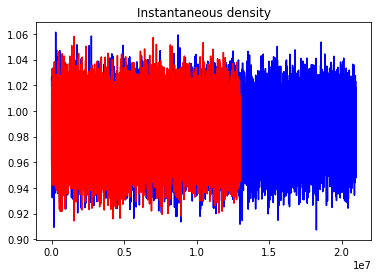

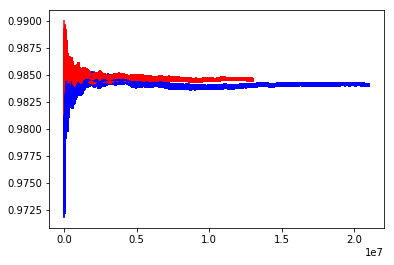

In [8]:
tip3p_new2 = pd.read_csv('results/prod/tip3p_modified2_216_prod.csv', names=["step", "U", "Temperature", "Density"], skiprows=1)

%matplotlib inline
from pylab import *

# Plot instantaneous density for original and new
plot( np.array(tip3p.step), np.array(tip3p.Density), 'b-')
plot( np.array(tip3p_new2.step), np.array(tip3p_new2.Density), 'r-')
title('Instantaneous density')

# Clip out unequilibrated region
density_ts = np.array(tip3p.Density)
[t0, g, Neff] = ts.detectEquilibration(density_ts, nskip=1000)
density_ts = density_ts[t0:]
stepnrs = np.array(tip3p.step[t0:])
density_ts_new2 = np.array(tip3p_new2.Density)
[t0, g, Neff] = ts.detectEquilibration(density_ts_new2, nskip=1000)
density_ts_new2 = density_ts_new2[t0:]
stepnrs_new2 = np.array(tip3p_new2.step[t0:])

# Compute mean density up to the present at each time, along with associated uncertainty
mean_density = [ density_ts[0:i].mean() for i in range(2, len(density_ts)) ]
mean_density_stderr = [ ]
for i in range(2,len(density_ts)):
    g = ts.statisticalInefficiency( density_ts[0:i])
    stderr = density_ts[0:i].std()/sqrt(i/g)
    mean_density_stderr.append(stderr)
mean_density_new2 = [ density_ts_new2[0:i].mean() for i in range(2, len(density_ts_new2)) ]
mean_density_new2_stderr = [ ]
for i in range(2,len(density_ts_new2)):
    g = ts.statisticalInefficiency( density_ts_new2[0:i])
    stderr = density_ts_new2[0:i].std()/sqrt(i/g)
    mean_density_new2_stderr.append(stderr)

figure()
#plot(stepnrs[2:], mean_density )
errorbar(stepnrs[20:], mean_density[18:], yerr=mean_density_stderr[18:], fmt='b-' )
errorbar(stepnrs_new2[20:], mean_density_new2[18:], yerr= mean_density_new2_stderr[18:], fmt='r-')
show()

In [10]:
# Just do statistics and print, also
[t0, g, Neff] = ts.detectEquilibration(density_ts, nskip=1000)
density_mean_stderr = density_ts.std() / np.sqrt(Neff)
print("Mean density of normal TIP3P: %.4g+/-%.3g" % (density_ts.mean(), density_mean_stderr))
[t0, g, Neff] = ts.detectEquilibration(density_ts_new2, nskip=1000)
density_mean_new2_stderr = density_ts_new2.std() / np.sqrt(Neff)
print("Mean density of modified TIP3P: %.4g+/-%.3g" % (density_ts_new2.mean(), density_mean_new2_stderr))

Mean density of normal TIP3P: 0.9841+/-0.0002
Mean density of modified TIP3P: 0.9845+/-0.0002


What difference is acceptable? Folowing [Shirts *et al.*](dx.doi.org/10.1021/jp0735987) we can estimate the difference in pressure corresponding to a specified difference in density from the isothermal compressibility of water, which we can take as $\beta = 4.5\times 10^{-5} atm^{-1}$. The resulting pressure difference is $\delta P = -(4.5\times 10^{-5} atm^{-1})^{-1} \times \frac{\delta \rho}{\rho}$; here at a tolerance of $2\times 10^{-4}$ g/mL, $\frac{\delta {\rho}}{\rho} = 2\times 10^{-4}$ and we obtain a value of $4.4$ atm, indicating a density difference at even this level corresponds to a rather significant difference in pressure.
To get this down even further we might need to convergence density calculations even more tightly and *perhaps* take an even smaller value for $\epsilon$.

However, first, it is probably worth checking that we can reproduce the crashes and that this epsilon value alleviates it.

**Dropping out to separate notebook to assess dimer energy problem**

Relevant notebook is `Dimer energetics.ipynb`.
This value DOES fix the energetic problem.

Since we don't actually plan on ever applying these parameters to TIP3P water, I think we ought to just go straight to density validation at this point and see what happens with these parameters when applied to densities.